## **1. Preprocesamiento**

### *Limpiar archivos CSV*

In [1]:
import os  # Manejo de rutas de archivos y carpetas 
import spacy  # Lematización de texto
import nltk  # Tokenización y stopwords
import pandas as pd  # Procesamiento de datos
import re  # Expresiones regulares
from concurrent.futures import ThreadPoolExecutor  # Procesamiento en paralelo con threads
import subprocess  # Para ejecutar comandos del sistema

# Verifica si las stopwords en español ya están descargadas
try:
    stop_words = set(nltk.corpus.stopwords.words('spanish'))
except LookupError:
    print("Descargando stopwords de NLTK...")
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('spanish'))

# Verifica si el modelo de spaCy para español ya está descargado
try:
    nlp = spacy.load('es_core_news_sm')
except OSError:
    print("Descargando modelo de spaCy para español...")    
    subprocess.run(["python", "-m", "spacy", "download", "es_core_news_sm"])
    nlp = spacy.load('es_core_news_sm')

# Directorio donde están los archivos CSV
ruta_csv = 'C:/USFQ/9_Semestre/DataMining/TextMining'

# Función para lematizar el texto usando spaCy
def lematizar_batch(texto):
    doc = nlp(texto.lower())  # Procesar el texto y convertir a minúsculas
    return ' '.join([token.lemma_ for token in doc if not token.is_punct])

# Función para limpiar el texto de un archivo CSV
def limpiar_csv(texto):
    lematizado = lematizar_batch(texto)  # Lematizar el texto

    # Eliminar palabras que consisten solo en números
    lematizado = re.sub(r'\b\d+\b', '', lematizado)
    
    # Eliminar palabras de menor o igual a 3 caracteres
    palabras_limpias = [palabra for palabra in lematizado.split() if len(palabra) > 3]
    
    # Eliminar secuencias de letras repetidas
    palabras_limpias = [re.sub(r'(.)\1+', r'\1', palabra) for palabra in palabras_limpias]
    
    # Eliminar stopwords
    palabras_limpias = [palabra for palabra in palabras_limpias if palabra not in stop_words]
    
    # Unir las palabras limpias en un solo texto
    texto_limpio = ' '.join(palabras_limpias)
    
    return texto_limpio

# Procesar DataFrame usando la limpieza de texto en todas las columnas de tipo texto
def procesar_dataframe(df):
    for col in df.select_dtypes(include=[object]):  # Seleccionar solo columnas que contienen texto
        df[col] = df[col].apply(lambda x: limpiar_csv(x) if isinstance(x, str) else x)
    return df

# Función para procesar archivos CSV
def procesar_archivo_csv(ruta_archivo, nombre_archivo):
    try:
        # Cargar el archivo CSV en un DataFrame de pandas
        df = pd.read_csv(ruta_archivo)
        # Procesar el archivo aplicando la limpieza de texto
        df = procesar_dataframe(df)
        # Crear el nombre del archivo con el sufijo '_clean'
        nombre_archivo_clean = f"{os.path.splitext(nombre_archivo)[0]}_clean.csv"
        # Guardar el archivo procesado con el nuevo nombre
        ruta_archivo_limpio = os.path.join(ruta_csv, nombre_archivo_clean)
        df.to_csv(ruta_archivo_limpio, index=False, encoding='utf-8-sig')
        # Mostrar solo el nombre del archivo procesado
        print(f"CSV procesado: {nombre_archivo_clean}")
    except Exception as e:
        print(f"Error al procesar el archivo {nombre_archivo}: {e}")

# Función para procesar múltiples archivos de manera paralela usando threads
def procesar_archivos_en_paralelo(archivos):
    with ThreadPoolExecutor() as executor:
        executor.map(limpiar_archivo, archivos)

# Función para limpiar archivo individual
def limpiar_archivo(nombre_archivo):
    if nombre_archivo.endswith('.csv'): 
        ruta_archivo = os.path.join(ruta_csv, nombre_archivo)
        procesar_archivo_csv(ruta_archivo, nombre_archivo)  
    else:
        print(f"No se pudo limpiar el archivo {nombre_archivo}. Solo se admiten archivos .csv")

# Lista de archivos CSV a procesar
archivos = ['preguntas_y_aclaraciones.csv', 'process_info.csv']

# Procesar archivos en paralelo usando threads
procesar_archivos_en_paralelo(archivos)

CSV procesado: process_info_clean.csv
CSV procesado: preguntas_y_aclaraciones_clean.csv


### *Limpiar archivos TXT*

In [2]:
import shutil  # Para mover o eliminar archivos y directorios
import re  # Expresiones regulares, útil para buscar y manipular patrones en el texto
from nltk.corpus import stopwords  # Carga el conjunto de palabras irrelevantes (stopwords) en español
from concurrent.futures import ThreadPoolExecutor  # Permite ejecutar tareas en hilos de forma concurrente
import os  # Manejo de rutas de archivos y carpetas
from nltk.tokenize import word_tokenize
import spacy  # Lematización de texto
import nltk  # Tokenización y stopwords
import subprocess  # Ejecutar comandos en la terminal

# Descargar 'punkt' si no está disponible (para tokenización)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Cargar el modelo de spaCy para español
try:
    nlp = spacy.load('es_core_news_sm')
except OSError:
    print("Descargando modelo de spaCy para español...")
    subprocess.run(["python", "-m", "spacy", "download", "es_core_news_sm"])
    nlp = spacy.load('es_core_news_sm')

# Directorios
ruta_base_txt = 'C:/USFQ/9_Semestre/DataMining/TextMining/Procesos'  # Ruta de la carpeta con los archivos originales
ruta_clean_txt = 'C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean'  # Ruta donde se guardarán los archivos limpios

# Función para gestionar (crear/eliminar) la carpeta donde se guardarán los archivos procesados
def gestionar_carpeta_clean(ruta_clean):
    try:
        if os.path.exists(ruta_clean):
            print(f'La carpeta {ruta_clean} ya existe, eliminando y recreando...')
            shutil.rmtree(ruta_clean)  # Elimina la carpeta y su contenido
        os.makedirs(ruta_clean)  # Crea la carpeta limpia
        print(f'Carpeta {ruta_clean} creada nuevamente.')
    except Exception as e:
        print(f'Error al gestionar la carpeta {ruta_clean}: {e}')

# Función para limpiar y lematizar solo los sustantivos del texto
# Lista de siglas irrelevantes o ruido
siglas_inecesarias = ['etc']

def limpiar_txt(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Lematizar el texto
    doc = nlp(texto)
    texto = ' '.join([token.lemma_ for token in doc if token.pos_ == 'NOUN'])
    
    # Remover caracteres especiales, excepto letras, espacios y tildes
    texto = re.sub(r'[^a-záéíóúÁÉÍÓÚñÑ\s]', '', texto)
    
    # Tokenizar el texto
    palabras = word_tokenize(texto)
    
    # Eliminar stopwords en español
    stop_words = set(stopwords.words('spanish'))
    palabras_limpias = [palabra for palabra in palabras if palabra not in stop_words]
    
    # Eliminar palabras de menos de 3 caracteres
    palabras_limpias = [palabra for palabra in palabras_limpias if len(palabra) >= 3]
    
    # Eliminar secuencias de letras repetidas (ej. "aaa", "bbb")
    palabras_limpias = [palabra for palabra in palabras_limpias if not re.fullmatch(r'(.)\1+', palabra)]
    
    # Eliminar siglas irrelevantes
    palabras_limpias = [palabra for palabra in palabras_limpias if palabra not in siglas_inecesarias]
    
    # Unir las palabras limpias
    texto_limpio = ' '.join(palabras_limpias)
    
    return texto_limpio

# Función para procesar cada archivo de texto: leer, limpiar y guardar el archivo limpio
def procesar_archivo(ruta_archivo, ruta_archivo_clean):
    try:
        with open(ruta_archivo, 'r', encoding='utf-8') as file:
            contenido = file.read()
        # Limpiar y normalizar el contenido
        contenido_limpio = limpiar_txt(contenido)
        # Guardar el archivo limpio
        with open(ruta_archivo_clean, 'w', encoding='utf-8') as file_clean:
            file_clean.write(contenido_limpio)
        print(f'TXT Procesado: {os.path.basename(ruta_archivo)}')
    except Exception as e:
        print(f'Error al procesar el archivo {ruta_archivo}: {e}')

# Función para procesar los archivos en cada carpeta usando hilos (concurrencia)
def procesar_archivos(carpeta_raiz, ruta_relativa):
    ruta_nueva_carpeta = os.path.join(ruta_clean_txt, ruta_relativa)
    if not os.path.exists(ruta_nueva_carpeta):
        os.makedirs(ruta_nueva_carpeta)
    archivos_txt = [archivo for archivo in os.listdir(carpeta_raiz) if archivo.endswith('.txt')]
    with ThreadPoolExecutor() as executor:
        for archivo in archivos_txt:
            ruta_archivo = os.path.join(carpeta_raiz, archivo)
            ruta_archivo_clean = os.path.join(ruta_nueva_carpeta, archivo)
            executor.submit(procesar_archivo, ruta_archivo, ruta_archivo_clean)

# Función principal para recorrer carpetas y procesar los archivos .txt
def limpiar_procesos(ruta_base):
    for carpeta_raiz, _, _ in os.walk(ruta_base):
        ruta_relativa = os.path.relpath(carpeta_raiz, ruta_base)
        procesar_archivos(carpeta_raiz, ruta_relativa)

# Ejecutar el proceso de limpieza
def ejecutar_limpieza():
    gestionar_carpeta_clean(ruta_clean_txt)
    limpiar_procesos(ruta_base_txt)
    print("Limpieza de archivos completada.")

# Ejecutar la limpieza
ejecutar_limpieza()

La carpeta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean ya existe, eliminando y recreando...
Carpeta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean creada nuevamente.
TXT Procesado: 3_formulario_de_compromiso_de_asociacion_o_consorcio.txt
TXT Procesado: 0_indice_de_subasta_inversa_electronica1.txt
TXT Procesado: 5_condiciones_generales_del_contrato_de_subasta_inversa_electronica_bienes_y_servicios.txt
TXT Procesado: condiciones_particulares_del_contrato_de_subasta_inversa_electronica.txt
TXT Procesado: tdr_maquinaria_conv-gpa-signed.txt
TXT Procesado: ush_pliego_plisubinv-signed.txt
TXT Procesado: 1_condiciones_particulares_del_pliego_de_subasta_inversa_electronica1.txtTXT Procesado: 3_formulario_de_la_oferta_de_subasta_inversa_electronica_bienes_y_servicios.txt

TXT Procesado: 2_condiciones_generales_del_pliego_de_subasta_inversa_electronica_bienes_y_servicios.txt
TXT Procesado: formulario_consorcio.txt
TXT Procesado: formulario_de_cumplimiento_res_044.txt
TXT Proc

## **2. Vectores TF-IDF**

In [3]:
import pandas as pd
import os

# Cargar archivos CSV
process_info = pd.read_csv('C:/USFQ/9_Semestre/DataMining/TextMining/process_info_clean.csv')
preguntas_y_aclaraciones = pd.read_csv('C:/USFQ/9_Semestre/DataMining/TextMining/preguntas_y_aclaraciones_clean.csv')
sample_files = pd.read_csv('C:/USFQ/9_Semestre/DataMining/TextMining//sample_files.csv')

# Verificar que los datos se cargaron correctamente
print(process_info.head())
print(preguntas_y_aclaraciones.head())
print(sample_files.head())

   sl_contract_id                                         sd_entidad  \
0         1752147  gobierno autonomo descentralizado municipal ca...   
1         1689929  centro clinico quirurgico ambulatorio hospital...   
2         1737580  empresa eléctrico público estratégico corporac...   
3         1699371                         hospital básico-esmeraldas   
4         1712786        direcion distrital 09d04 febr cordero salud   

                                sd_objeto_de_proceso  sie_ic_promedio  
0   adquisicion maquín excavadora oruga gadm cumanda             0.86  
1  adquisición primero requerimiento fármaco cata...             0.73  
2                    corp adquisicion selo seguridad             0.63  
3  adquisicion medicamento cuyo grupo terapéutico...             0.73  
4  contratación servicio vigilancia seguridad uni...             0.55  
   sl_contract_id  pregunta_id  \
0         1728041       326428   
1         1706638       332456   
2         1706638       332449   

In [4]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer

def textos_individuales_col1(sample_files):
    textos_por_documento = {}  # Diccionario para almacenar contenido de documentos por contract_id
    rutas_por_documento = {}   # Diccionario para almacenar rutas completas de los documentos por contract_id

    # Procesar los archivos de texto de los procesos (cada archivo es un documento independiente)
    for index, row in sample_files.iterrows():
        sl_contract_id = str(row['sl_contract_id'])
        file_name = row['file_name']  # Nombre del archivo

        # Ajustar la ruta para acceder a la carpeta correcta
        file_path = f"C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/{sl_contract_id}/{file_name}.txt"

        try:
            # Verificar si el archivo existe
            if os.path.exists(file_path):
                # Leer el contenido del archivo
                with open(file_path, 'r', encoding='utf-8') as file:
                    contenido = file.read()
                
                # Almacenar el contenido del documento
                if sl_contract_id in textos_por_documento:
                    textos_por_documento[sl_contract_id].append(contenido)
                else:
                    textos_por_documento[sl_contract_id] = [contenido]
                
                # Almacenar la ruta del archivo
                if sl_contract_id in rutas_por_documento:
                    rutas_por_documento[sl_contract_id].append(file_path)
                else:
                    rutas_por_documento[sl_contract_id] = [file_path]
            else:
                print(f"Archivo no encontrado: {file_path}")

        except Exception as e:
            print(f"Error al leer el archivo {file_path}: {e}")

    # Retornar ambos: el contenido y las rutas completas de los documentos
    return textos_por_documento, rutas_por_documento

# Llamar a la función para obtener los textos individuales y las rutas (colección COL1)
textos_individuales_corpus_col1, rutas_documentos_col1 = textos_individuales_col1(sample_files)

# Descomponer los documentos en una lista donde cada documento es independiente, pero guardamos el proceso al que pertenecen
documentos_col1 = []  # Aquí se almacena el contenido de cada documento
procesos_col1 = []    # Aquí se almacena el proceso al que pertenece cada documento
rutas_col1 = []       # Aquí se almacena la ruta completa de cada documento

for proceso, documentos in textos_individuales_corpus_col1.items():
    for idx, documento in enumerate(documentos):
        documentos_col1.append(documento)  # Agregar el contenido del documento a la lista
        procesos_col1.append(proceso)      # Mantener el registro del proceso al que pertenece
        rutas_col1.append(rutas_documentos_col1[proceso][idx])  # Agregar la ruta completa a la lista

# Vectorizar los documentos individuales de COL1
vectorizer_col1 = TfidfVectorizer()
X_tfidf_col1 = vectorizer_col1.fit_transform(documentos_col1)

# Mostrar la forma de la matriz TF-IDF resultante para COL1
print(f"Matriz TF-IDF de COL1 con forma: {X_tfidf_col1.shape}")

# Verificar que los procesos están alineados con los documentos, imprimiendo el nombre del archivo
for i in range(20):  # Mostrar los primeros 20 documentos y sus procesos asociados
    print(f"Documento {i+1} pertenece al proceso {procesos_col1[i]} con ruta {rutas_col1[i]}")

# Verificar las dimensiones del diccionario de textos individuales
print("Número de procesos en COL1:", len(textos_individuales_corpus_col1))

Matriz TF-IDF de COL1 con forma: (828, 10755)
Documento 1 pertenece al proceso 1721524 con ruta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/tdr_logistica_actualizado.txt
Documento 2 pertenece al proceso 1721524 con ruta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/condiciones_generales_de_los_pliegos.txt
Documento 3 pertenece al proceso 1721524 con ruta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/condiciones_generales_del_contrato.txt
Documento 4 pertenece al proceso 1721524 con ruta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/condiciones_particulares_de_los_contratos.txt
Documento 5 pertenece al proceso 1721524 con ruta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/formularios_actualizados_1-1_y_1-3.txt
Documento 6 pertenece al proceso 1721524 con ruta C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/formulario-unico-oferta-subasta-inversa-bys.txt
Documento 7 pertenece al pr

In [6]:
# Función para concatenar textos de los archivos de procesos y preguntas/respuestas
def concatenar_textos(sample_files, preguntas_y_aclaraciones):
    textos_por_proceso = {}

    # Procesar los archivos de texto de los procesos
    for index, row in sample_files.iterrows():
        sl_contract_id = str(row['sl_contract_id'])
        file_name = row['file_name']  # Ajustar para obtener el nombre del archivo

        # Ajustar la ruta para acceder a la carpeta correcta
        file_path = f"C:/USFQ/9_Semestre/DataMining/TextMining//Procesos_Clean/{sl_contract_id}/{file_name}.txt"

        try:
            # Leer el contenido del archivo
            with open(file_path, 'r', encoding='utf-8') as file:
                contenido = file.read()
                contenido_limpio = limpiar_txt(contenido)  # Aplicar la función de limpieza

            # Concatenar contenido en caso de que ya existan otros archivos para ese proceso
            if sl_contract_id in textos_por_proceso:
                textos_por_proceso[sl_contract_id] += ' ' + contenido_limpio
            else:
                textos_por_proceso[sl_contract_id] = contenido_limpio
        except Exception as e:
            print(f"Error al leer el archivo {file_path}: {e}")

    # Procesar las preguntas y respuestas y concatenarlas al texto del proceso
    for index, row in preguntas_y_aclaraciones.iterrows():
        sl_contract_id = str(row['sl_contract_id'])

        # Convertir valores nulos a cadenas vacías antes de concatenar
        pregunta_aclaracion = str(row['pregunta_aclaracion']) if not pd.isna(row['pregunta_aclaracion']) else ''
        respuesta_aclaracion = str(row['respuesta_aclaracion']) if not pd.isna(row['respuesta_aclaracion']) else ''

        pregunta_respuesta = pregunta_aclaracion + ' ' + respuesta_aclaracion
        pregunta_respuesta_limpia = limpiar_txt(pregunta_respuesta)

        if sl_contract_id in textos_por_proceso:
            textos_por_proceso[sl_contract_id] += ' ' + pregunta_respuesta_limpia
        else:
            textos_por_proceso[sl_contract_id] = pregunta_respuesta_limpia

    return textos_por_proceso

# Llamar a la función para concatenar los textos (COL2)
textos_por_proceso = concatenar_textos(sample_files, preguntas_y_aclaraciones)

from sklearn.feature_extraction.text import TfidfVectorizer

# Crear una lista con los textos preprocesados y concatenados por proceso
corpus = list(textos_por_proceso.values())
contract_ids = list(textos_por_proceso.keys())

# Crear el vectorizador TF-IDF y ajustar con el contenido completo
vectorizer_col2 = TfidfVectorizer()
X_tfidf_col2 = vectorizer_col2.fit_transform(corpus)  # Aquí estamos haciendo fit con todo el corpus

# Mostrar la forma de la matriz TF-IDF resultante para COL2
print(f"Matriz TF-IDF de COL2 con forma: {X_tfidf_col2.shape}")

# Mostrar las dimensiones del dicccionario de la colección COL2
print("Número de procesos en COL2:", len(textos_por_proceso))

for i in range(20):  # Mostrar los primeros 5 documentos y sus procesos asociados
    print(f"Documento {i+1} pertenece al proceso {contract_ids[i]}")

Matriz TF-IDF de COL2 con forma: (107, 4969)
Número de procesos en COL2: 107
Documento 1 pertenece al proceso 1721524
Documento 2 pertenece al proceso 1699371
Documento 3 pertenece al proceso 1745524
Documento 4 pertenece al proceso 1758687
Documento 5 pertenece al proceso 1704225
Documento 6 pertenece al proceso 1747722
Documento 7 pertenece al proceso 1686226
Documento 8 pertenece al proceso 1709477
Documento 9 pertenece al proceso 1755826
Documento 10 pertenece al proceso 1728041
Documento 11 pertenece al proceso 1682008
Documento 12 pertenece al proceso 1743489
Documento 13 pertenece al proceso 1709875
Documento 14 pertenece al proceso 1706638
Documento 15 pertenece al proceso 1716637
Documento 16 pertenece al proceso 1730092
Documento 17 pertenece al proceso 1736958
Documento 18 pertenece al proceso 1718330
Documento 19 pertenece al proceso 1750232
Documento 20 pertenece al proceso 1682777


## **3. Cálculo de TF, DF, IDF y TF-IDF para COL1 y COL2**

### A. Cálculo para COL1

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Ya tienes el TfidfVectorizer para COL1
# Mostramos los nombres de los términos (palabras) del vocabulario de COL1
terms_col1 = vectorizer_col1.get_feature_names_out()

# Obtenemos la matriz de cuenta de términos (TF y DF) usando CountVectorizer
count_vectorizer_col1 = CountVectorizer()
X_count_col1 = count_vectorizer_col1.fit_transform(documentos_col1)

# TF: Frecuencia de términos en todos los documentos de COL1
tf_col1 = np.sum(X_count_col1.toarray(), axis=0)

# DF: Número de documentos en los que aparece cada término en COL1
df_col1 = np.sum(X_count_col1.toarray() > 0, axis=0)

# IDF: Ya está calculado en el TfidfVectorizer
idf_col1 = vectorizer_col1.idf_

# Mostrar resultados para los primeros 15 términos
for i in range(15):
    term = terms_col1[i]
    print(f"Término: {term}")
    print(f"TF (Frecuencia de Término) en COL1: {tf_col1[i]}")
    print(f"DF (Frecuencia de Documento) en COL1: {df_col1[i]}")
    print(f"IDF (Frecuencia Inversa de Documento) en COL1: {idf_col1[i]}")
    
    # Mostrar el valor de TF-IDF del término en los primeros documentos
    print(f"TF-IDF en los primeros documentos de COL1: {X_tfidf_col1[:, i].toarray().flatten()[:20]}")
    print(f"TF-IDF en los primeros documentos de COL1: {X_tfidf_col1[:, i].toarray().flatten().shape}")
    print("-" * 40)

Término: aac
TF (Frecuencia de Término) en COL1: 3
DF (Frecuencia de Documento) en COL1: 2
IDF (Frecuencia Inversa de Documento) en COL1: 6.621607866467185
TF-IDF en los primeros documentos de COL1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TF-IDF en los primeros documentos de COL1: (828,)
----------------------------------------
Término: aad
TF (Frecuencia de Término) en COL1: 1
DF (Frecuencia de Documento) en COL1: 1
IDF (Frecuencia Inversa de Documento) en COL1: 7.02707297457535
TF-IDF en los primeros documentos de COL1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TF-IDF en los primeros documentos de COL1: (828,)
----------------------------------------
Término: aarma
TF (Frecuencia de Término) en COL1: 1
DF (Frecuencia de Documento) en COL1: 1
IDF (Frecuencia Inversa de Documento) en COL1: 7.02707297457535
TF-IDF en los primeros documentos de COL1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TF-IDF en los primeros documentos d

### B. Cálculo para COL2

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Mostramos los nombres de los términos (palabras) del vocabulario de COL2
terms_col2 = vectorizer_col2.get_feature_names_out()

# Obtenemos la matriz de cuenta de términos (TF y DF) usando CountVectorizer
count_vectorizer_col2 = CountVectorizer()
X_count_col2 = count_vectorizer_col2.fit_transform(textos_por_proceso.values())

# TF: Frecuencia de términos en todos los documentos de COL1
tf_col2 = np.sum(X_count_col2.toarray(), axis=0)

# DF: Número de documentos en los que aparece cada término en COL1
df_col2 = np.sum(X_count_col2.toarray() > 0, axis=0)

# IDF: Ya está calculado en el TfidfVectorizer
idf_col2 = vectorizer_col2.idf_

# Mostrar resultados para los primeros 15 términos
for i in range(15):
    term = terms_col2[i]
    print(f"Término: {term}")
    print(f"TF (Frecuencia de Término) en COL2: {tf_col2[i]}")
    print(f"DF (Frecuencia de Documento) en COL2: {df_col2[i]}")
    print(f"IDF (Frecuencia Inversa de Documento) en COL2: {idf_col2[i]}")
    
    # Mostrar el valor de TF-IDF del término en los primeros documentos
    print(f"TF-IDF en los primeros documentos de COL2: {X_tfidf_col2[:, i].toarray().flatten()[:20]}")
    print(f"TF-IDF en los primeros documentos de COL2: {X_tfidf_col2[:, i].toarray().flatten().shape}")
    print("-" * 40)

Término: abandono
TF (Frecuencia de Término) en COL2: 4
DF (Frecuencia de Documento) en COL2: 4
IDF (Frecuencia Inversa de Documento) en COL2: 4.072693314690119
TF-IDF en los primeros documentos de COL2: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01871834 0.         0.         0.         0.         0.
 0.         0.        ]
TF-IDF en los primeros documentos de COL2: (107,)
----------------------------------------
Término: abasteciemiento
TF (Frecuencia de Término) en COL2: 1
DF (Frecuencia de Documento) en COL2: 1
IDF (Frecuencia Inversa de Documento) en COL2: 4.9889840465642745
TF-IDF en los primeros documentos de COL2: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
TF-IDF en los primeros documentos de COL2: (107,)
----------------------------------------
Término: abastecimiento
TF (Frecuencia de Término) en COL2: 1
DF (Frecuencia de Documento) en COL2: 1
IDF (Frecuencia Inversa de Documento)

## **SIMILARIDAD DEL COSENO PARA COL1 Y COL2**

### A. COL1

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similaridad del coseno entre los vectores de Col1 (documentos individuales)
cosine_sim_col1 = cosine_similarity(X_tfidf_col1)

# Mostrar las primeras 5 filas de la matriz de similaridad de Col1
print("Similaridad del coseno para COL1:")
print(cosine_sim_col1[:5, :5])  # Muestra solo una parte de la matriz para los primeros 5 documentos

#dimensiones del cosine_sim_col1
#print("Dimensiones de la matriz de similaridad de COL1: ", cosine_sim_col1.shape)

Similaridad del coseno para COL1:
[[1.         0.23902249 0.23170936 0.19860174 0.16487823]
 [0.23902249 1.         0.63259109 0.5627415  0.57081283]
 [0.23170936 0.63259109 1.         0.68548089 0.45769336]
 [0.19860174 0.5627415  0.68548089 1.         0.33559308]
 [0.16487823 0.57081283 0.45769336 0.33559308 1.        ]]


### B. COL2

In [13]:
# Calcular la similaridad del coseno entre los vectores de Col2 (textos concatenados por proceso)
cosine_sim_col2 = cosine_similarity(X_tfidf_col2)

# Mostrar las primeras 5 filas de la matriz de similaridad de Col2
print("Similaridad del coseno para COL2:")
print(cosine_sim_col2[:5, :5])  # Muestra solo una parte de la matriz para los primeros 5 procesos

#dimensiones del cosine_sim_col2
print("Dimensiones de la matriz de similaridad de COL2: ", cosine_sim_col2.shape)

Similaridad del coseno para COL2:
[[1.         0.90140215 0.88114946 0.83519114 0.91547603]
 [0.90140215 1.         0.96306743 0.90174355 0.94375159]
 [0.88114946 0.96306743 1.         0.88277618 0.91925768]
 [0.83519114 0.90174355 0.88277618 1.         0.8755781 ]
 [0.91547603 0.94375159 0.91925768 0.8755781  1.        ]]
Dimensiones de la matriz de similaridad de COL2:  (107, 107)


## **RANKING DE DOCUMENTOS POR SIMILARIDAD EN COL1 Y EN COL2**

### COL1

In [16]:
def obtener_ranking_documentos(cosine_sim, rutas, documento_referencia_idx):
    # Mostrar con qué documento se están comparando los demás
    print(f"Comparando todos los documentos con el documento: {rutas[documento_referencia_idx]}")
    
    # Ordenar documentos por similaridad
    ranking = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)
    
    print(f"\nRanking de documentos similares al documento elegido ({rutas[documento_referencia_idx]}): ")
    for idx, sim in ranking[:20]:  # Mostrar los 20 documentos más similares
        print(f'Documento: {(rutas[idx])}, Similaridad: {sim}')

# Mostrar el ranking de documentos similares para el segundo documento en Col1
print(f"Ranking de documentos similares para el documento elegido en COL1:")
obtener_ranking_documentos(cosine_sim_col1[0], rutas_col1, 0)

Ranking de documentos similares para el documento elegido en COL1:
Comparando todos los documentos con el documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/tdr_logistica_actualizado.txt

Ranking de documentos similares al documento elegido (C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/tdr_logistica_actualizado.txt): 
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/tdr_logistica_actualizado.txt, Similaridad: 1.0
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/sie-30-2022_condiciones_particulares_de_los_pliegos-signed.txt, Similaridad: 0.7419103568869002
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1721524/sie-30-memos_comision_tecnica-signed-signed-signed.txt, Similaridad: 0.35744830951298673
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1680430/ush_pliego_pli_subinv-signed.txt, Similaridad: 0.338286067006474
Documento: C:/USFQ/9_Semestre/DataMinin

### 1. a. COL1

In [17]:
def ranking_documentos_por_query(query, sl_contract_id, textos_individuales_corpus_col1, rutas_col1):
    # Obtener los documentos del proceso dado (sl_contract_id)
    documentos_proceso = textos_individuales_corpus_col1.get(sl_contract_id, [])
    rutas_proceso = [ruta for idx, ruta in enumerate(rutas_col1) if procesos_col1[idx] == sl_contract_id]
    
    if not documentos_proceso:
        print(f"No se encontraron documentos para el proceso {sl_contract_id}")
        return

    # Vectorizar los documentos del proceso
    vectorizer_proceso = TfidfVectorizer()
    X_tfidf_proceso = vectorizer_proceso.fit_transform(documentos_proceso)
    
    # Vectorizar la consulta del usuario
    query_vector = vectorizer_proceso.transform([query])
    
    # Calcular la similaridad del coseno entre la consulta y los documentos del proceso
    cosine_sim_query = cosine_similarity(query_vector, X_tfidf_proceso).flatten()
    
    # Mostrar el ranking de los documentos más relevantes con respecto a la query
    ranking = sorted(enumerate(cosine_sim_query), key=lambda x: x[1], reverse=True)
    
    print(f"\nRanking de documentos del proceso {sl_contract_id} respecto a la consulta '{query}':")
    for idx, sim in ranking[:20]:  # Mostrar los 20 documentos más similares
        print(f'Documento: {rutas_proceso[idx]}, Similaridad: {sim}')


In [18]:
# Dada una consulta del usuario (query)
#query = "¿Cuál es el alcance del contrato?"
sl_contract_id = input("Ingrese el ID del contrato: ")
query = input("Ingrese su consulta: ")
ranking_documentos_por_query(query, sl_contract_id, textos_individuales_corpus_col1, rutas_col1)


Ranking de documentos del proceso 1736958 respecto a la consulta '¿Cuál es el alcance del contrato?':
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/proyecto_de_contrato.txt, Similaridad: 0.2835875656444468
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/4_especificaciones_motosoldadora-signed-signed.txt, Similaridad: 0.17301659375854672
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/2_condiciones_generales_del_pliego_de_subasta_inversa_electronica_bienes_y_servicios.txt, Similaridad: 0.1528058153938596
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/formulario-unico-oferta-subasta-inversa-bys.txt, Similaridad: 0.06970099405130982
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/formato_declaracion_juramentada.txt, Similaridad: 0.04194250918387501
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/5_estudio_de_mercado_motosolda

### 1. b. COL1

In [20]:
# Función para concatenar preguntas y respuestas para cada proceso
def concatenar_preguntas_respuestas(preguntas_y_aclaraciones):
    preguntas_por_proceso = {}
    
    for index, row in preguntas_y_aclaraciones.iterrows():
        sl_contract_id = str(row['sl_contract_id'])
        pregunta_aclaracion = str(row['pregunta_aclaracion']) if not pd.isna(row['pregunta_aclaracion']) else ''
        respuesta_aclaracion = str(row['respuesta_aclaracion']) if not pd.isna(row['respuesta_aclaracion']) else ''
        texto_completo = pregunta_aclaracion + ' ' + respuesta_aclaracion
        texto_completo_limpio = limpiar_txt(texto_completo)
        
        if sl_contract_id in preguntas_por_proceso:
            preguntas_por_proceso[sl_contract_id] += ' ' + texto_completo_limpio
        else:
            preguntas_por_proceso[sl_contract_id] = texto_completo_limpio
    
    return preguntas_por_proceso

# Llamamos a la función
preguntas_respuestas_corpus = concatenar_preguntas_respuestas(preguntas_y_aclaraciones)

# Concatenamos las preguntas y respuestas en un solo corpus para el análisis
corpus_preguntas_respuestas = list(preguntas_respuestas_corpus.values())
contract_ids_preguntas_respuestas = list(preguntas_respuestas_corpus.keys())

# Vectorizamos las preguntas y respuestas
vectorizer_preguntas_respuestas = TfidfVectorizer()
X_tfidf_preguntas_respuestas = vectorizer_preguntas_respuestas.fit_transform(corpus_preguntas_respuestas)

# Verificamos la forma de la matriz
print(f"Matriz TF-IDF para preguntas y respuestas con forma: {X_tfidf_preguntas_respuestas.shape}")

# Podemos ahora calcular la similaridad del coseno
cosine_sim_preguntas_respuestas = cosine_similarity(X_tfidf_preguntas_respuestas)

# Mostrar las primeras 5 filas de la matriz de similaridad
print("Similaridad del coseno para preguntas y respuestas:")
print(cosine_sim_preguntas_respuestas[:5, :5])

# Función para obtener el ranking de los documentos basados en preguntas y respuestas
def ranking_documentos_por_preguntas_respuestas(sl_contract_id, textos_individuales_corpus_col1, rutas_col1):
    # Obtener los documentos del proceso dado (sl_contract_id)
    documentos_proceso = textos_individuales_corpus_col1.get(sl_contract_id, [])
    rutas_proceso = [ruta for idx, ruta in enumerate(rutas_col1) if procesos_col1[idx] == sl_contract_id]
    
    if not documentos_proceso:
        print(f"No se encontraron documentos para el proceso {sl_contract_id}")
        return

    # Vectorizar los documentos del proceso
    vectorizer_proceso = TfidfVectorizer()
    X_tfidf_proceso = vectorizer_proceso.fit_transform(documentos_proceso)
    
    # Vectorizar las preguntas y respuestas del proceso
    preguntas_respuestas = preguntas_respuestas_corpus.get(sl_contract_id, '')
    query_vector = vectorizer_proceso.transform([preguntas_respuestas])
    
    # Calcular la similaridad del coseno entre las preguntas/respuestas y los documentos del proceso
    cosine_sim_query = cosine_similarity(query_vector, X_tfidf_proceso).flatten()
    
    # Mostrar el ranking de los documentos más relevantes con respecto a las preguntas/respuestas
    ranking = sorted(enumerate(cosine_sim_query), key=lambda x: x[1], reverse=True)
    
    print(f"\nRanking de documentos del proceso {sl_contract_id} respecto a las preguntas y respuestas:")
    for idx, sim in ranking[:20]:  # Mostrar los 20 documentos más similares
        print(f'Documento: {rutas_proceso[idx]}, Similaridad: {sim}')

# Ejemplo de uso para un proceso específico como sl_contract_id = "1736958"
sl_contract_id = input("Ingrese el ID del contrato para ranking de preguntas y aclaraciones: ")
ranking_documentos_por_preguntas_respuestas(sl_contract_id, textos_individuales_corpus_col1, rutas_col1)

Matriz TF-IDF para preguntas y respuestas con forma: (107, 1587)
Similaridad del coseno para preguntas y respuestas:
[[1.         0.         0.         0.         0.        ]
 [0.         1.         0.1252104  0.07280545 0.06444559]
 [0.         0.1252104  1.         0.         0.0177333 ]
 [0.         0.07280545 0.         1.         0.05754224]
 [0.         0.06444559 0.0177333  0.05754224 1.        ]]

Ranking de documentos del proceso 1736958 respecto a las preguntas y respuestas:
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/5_estudio_de_mercado_motosoldadora-signed-signed.txt, Similaridad: 0.14919560126035653
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/2_condiciones_generales_del_pliego_de_subasta_inversa_electronica_bienes_y_servicios.txt, Similaridad: 0.13319155809729305
Documento: C:/USFQ/9_Semestre/DataMining/TextMining/Procesos_Clean/1736958/3_estudios_previos_motosoldadora-signed-signed-signed.txt, Similaridad: 0.1

### COL2

In [21]:
def obtener_ranking_procesos(cosine_sim, contract_ids, proceso_referencia_idx):
    # Mostrar con qué proceso se están comparando los demás
    print(f"Comparando todos los procesos con el proceso: {contract_ids[proceso_referencia_idx]}")
    

    ranking = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)
    print(f"\nRanking de procesos similares al proceso elegido ({contract_ids[proceso_referencia_idx]}): ")
    for idx, sim in ranking[:20]:  # Mostrar los 20 procesos más similares
        print(f'Proceso: {contract_ids[idx]} (Similaridad: {sim})')


# Mostrar el ranking de procesos similares para el proceso con índice 17
print(f"Ranking de procesos similares para el proceso elegido en COL2:")
obtener_ranking_procesos(cosine_sim_col2[0], contract_ids, 0)

Ranking de procesos similares para el proceso elegido en COL2:
Comparando todos los procesos con el proceso: 1721524

Ranking de procesos similares al proceso elegido (1721524): 
Proceso: 1721524 (Similaridad: 1.0000000000000002)
Proceso: 1704225 (Similaridad: 0.9154760292420397)
Proceso: 1702911 (Similaridad: 0.9044342351704073)
Proceso: 1742137 (Similaridad: 0.9022629040174981)
Proceso: 1685410 (Similaridad: 0.9018373628940848)
Proceso: 1699371 (Similaridad: 0.9014021450781694)
Proceso: 1748550 (Similaridad: 0.9010408638313703)
Proceso: 1743301 (Similaridad: 0.9007822509941783)
Proceso: 1756064 (Similaridad: 0.8951482676292257)
Proceso: 1689258 (Similaridad: 0.8931059631023341)
Proceso: 1723420 (Similaridad: 0.8888008776773331)
Proceso: 1710100 (Similaridad: 0.8849357214373631)
Proceso: 1726894 (Similaridad: 0.884730628819771)
Proceso: 1737426 (Similaridad: 0.8817715312686837)
Proceso: 1745524 (Similaridad: 0.8811494563322315)
Proceso: 1682777 (Similaridad: 0.8809431632511877)
Proces

### 2. a. COL2

In [22]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Seleccionamos un proceso con sie_ic_promedio alto (ej: 0.85)
proceso_alto_riesgo = process_info[process_info['sie_ic_promedio'] >= 0.85].iloc[0]  # Seleccionar el primer proceso con alto riesgo
sl_contract_id_alto_riesgo = str(proceso_alto_riesgo['sl_contract_id'])

# Verificar si el proceso existe en la colección de textos
if sl_contract_id_alto_riesgo in textos_por_proceso:
    texto_proceso_alto_riesgo = textos_por_proceso[sl_contract_id_alto_riesgo]
    
    # Reutilizar el mismo vectorizador que usaste para COL2
    X_tfidf_proceso_alto_riesgo = vectorizer_col2.transform([texto_proceso_alto_riesgo])  # Notar que aquí uso .transform(), no .fit_transform()

    # Calcular la similaridad del coseno con todos los documentos de COL2
    cosine_sim_proceso_alto_riesgo = cosine_similarity(X_tfidf_proceso_alto_riesgo, X_tfidf_col2).flatten()

    # Crear un ranking descendente basado en la similaridad
    ranking = sorted(enumerate(cosine_sim_proceso_alto_riesgo), key=lambda x: x[1], reverse=True)

    # Imprimir los primeros 20 documentos del ranking
    print(f"Ranking de documentos similares al proceso {sl_contract_id_alto_riesgo} (sie_ic_promedio = {proceso_alto_riesgo['sie_ic_promedio']}):")
    for idx, sim in ranking[:20]:
        print(f"Documento {idx}, Similaridad: {sim}")
else:
    print(f"No se encontró el proceso con ID {sl_contract_id_alto_riesgo} en la colección COL2.")


Ranking de documentos similares al proceso 1752147 (sie_ic_promedio = 0.86):
Documento 101, Similaridad: 1.0000000000000002
Documento 24, Similaridad: 0.955195298368336
Documento 47, Similaridad: 0.9516430747701352
Documento 1, Similaridad: 0.9513748865113331
Documento 65, Similaridad: 0.9511075572627034
Documento 105, Similaridad: 0.950118717395566
Documento 41, Similaridad: 0.9483641827654531
Documento 89, Similaridad: 0.9474584964638083
Documento 94, Similaridad: 0.9470951504505848
Documento 20, Similaridad: 0.93514588250835
Documento 81, Similaridad: 0.9309841878345253
Documento 4, Similaridad: 0.9269455378531092
Documento 22, Similaridad: 0.92576165784783
Documento 19, Similaridad: 0.9234865143577228
Documento 2, Similaridad: 0.9211464662397839
Documento 28, Similaridad: 0.920237098982647
Documento 17, Similaridad: 0.918353737092822
Documento 82, Similaridad: 0.9182497051031175
Documento 43, Similaridad: 0.9138367946184602
Documento 66, Similaridad: 0.912398762673803


### 2. b. COL2

In [23]:
pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\Johana\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Número de procesos: 107, Número de entradas en sie_ic_promedio: 107


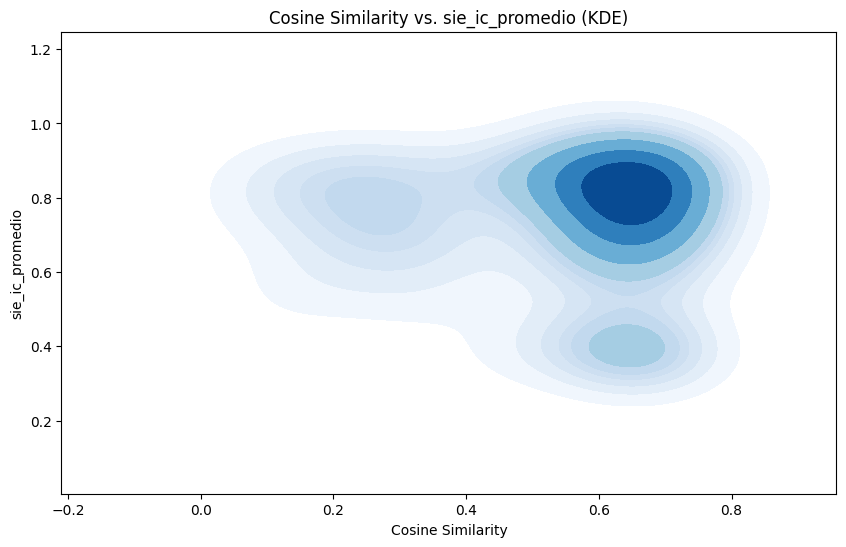

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Reutilizamos el vectorizador de COL2 para garantizar coherencia
vectorizer = TfidfVectorizer()

# Vectorizar todos los textos concatenados de COL2
corpus_col2 = list(textos_por_proceso.values())  # Los textos de COL2 ya concatenados por proceso
X_tfidf_col2 = vectorizer.fit_transform(corpus_col2)

# Calcular la similaridad del coseno entre todos los documentos de COL2
cosine_sim_col2 = cosine_similarity(X_tfidf_col2)

# Extraer el índice promedio de similaridad por proceso (similaridad promedio con todos los demás documentos)
similaridades_promedio = cosine_sim_col2.mean(axis=1)

# Asegúrate de que 'similaridades_promedio' tenga la misma longitud que 'sie_ic_promedio'
print(f"Número de procesos: {len(similaridades_promedio)}, Número de entradas en sie_ic_promedio: {process_info['sie_ic_promedio'].shape[0]}")

# Crear un gráfico KDE (Kernel Density Estimation)
plt.figure(figsize=(10, 6))
sns.kdeplot(x=similaridades_promedio, y=process_info['sie_ic_promedio'], fill=True, cmap="Blues", thresh=0.1)
plt.title('Cosine Similarity vs. sie_ic_promedio (KDE)')
plt.xlabel('Cosine Similarity')
plt.ylabel('sie_ic_promedio')
plt.show()

### 2. c. COL2

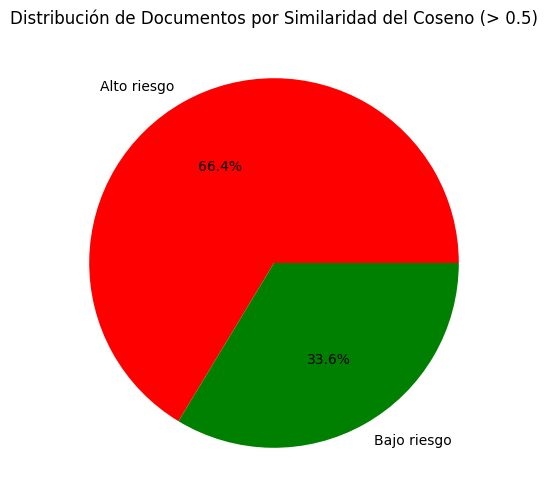

In [26]:
# Proporción de documentos con similaridad > 0.5
alto_riesgo_similaridad = sum(similaridades_promedio > 0.5)
bajo_riesgo_similaridad = sum(similaridades_promedio <= 0.5)

# Gráfico tipo pastel basado en la similaridad del coseno
plt.figure(figsize=(6, 6))
plt.pie([alto_riesgo_similaridad, bajo_riesgo_similaridad], labels=["Alto riesgo", "Bajo riesgo"], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Distribución de Documentos por Similaridad del Coseno (> 0.5)')
plt.show()

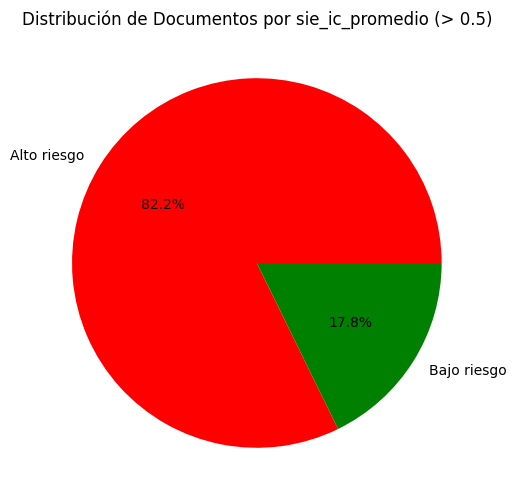

In [27]:
# Proporción de documentos con sie_ic_promedio > 0.5
alto_riesgo_real = sum(process_info['sie_ic_promedio'] > 0.5)
bajo_riesgo_real = sum(process_info['sie_ic_promedio'] <= 0.5)

# Gráfico tipo pastel basado en el índice de riesgo real
plt.figure(figsize=(6, 6))
plt.pie([alto_riesgo_real, bajo_riesgo_real], labels=["Alto riesgo", "Bajo riesgo"], autopct='%1.1f%%', colors=['red', 'green'])
plt.title('Distribución de Documentos por sie_ic_promedio (> 0.5)')
plt.show()

Matriz de similaridad (dimensión [n x n]):
[[1.         0.90140215 0.88114946 ... 0.71322769 0.90183736 0.06004192]
 [0.90140215 1.         0.96306743 ... 0.70412814 0.9963104  0.05882027]
 [0.88114946 0.96306743 1.         ... 0.69294015 0.96383713 0.06371834]
 ...
 [0.71322769 0.70412814 0.69294015 ... 1.         0.70063357 0.04736194]
 [0.90183736 0.9963104  0.96383713 ... 0.70063357 1.         0.05813559]
 [0.06004192 0.05882027 0.06371834 ... 0.04736194 0.05813559 1.        ]]

Vector columna con la similaridad promedio de cada documento (dimensión [n x 1]):
[0.65313593 0.68773389 0.67581289 0.657791   0.67914831 0.55964201
 0.5935396  0.41509041 0.67491365 0.34605236 0.66913208 0.07988589
 0.24649975 0.31378735 0.63670894 0.63355586 0.5238909  0.66225204
 0.5566516  0.67392598 0.68381954 0.27816473 0.68035274 0.29698196
 0.68760518 0.20949569 0.64025732 0.59067329 0.67794319 0.68403508
 0.52981963 0.45516138 0.35055338 0.31248033 0.6064364  0.52994481
 0.24771709 0.66680387 0.649

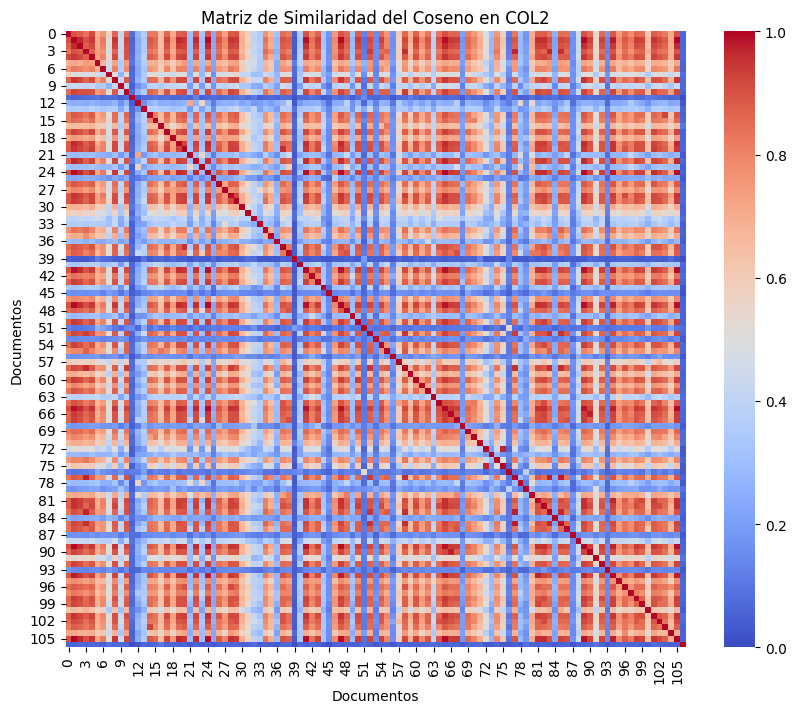

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similaridad del coseno entre todos los documentos de COL2
cosine_sim_col2 = cosine_similarity(X_tfidf_col2)

# Calcular el vector columna con la similaridad promedio de cada documento con respecto a los demás
similaridades_promedio_col2 = cosine_sim_col2.mean(axis=1)

# Mostrar la matriz de similaridad y el vector de similaridades promedio
print("Matriz de similaridad (dimensión [n x n]):")
print(cosine_sim_col2)

print("\nVector columna con la similaridad promedio de cada documento (dimensión [n x 1]):")
print(similaridades_promedio_col2)

# Graficar la matriz de similaridad del coseno de los docs en la COL2

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_col2, annot=False, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Matriz de Similaridad del Coseno en COL2")
plt.xlabel("Documentos")
plt.ylabel("Documentos")
plt.show()



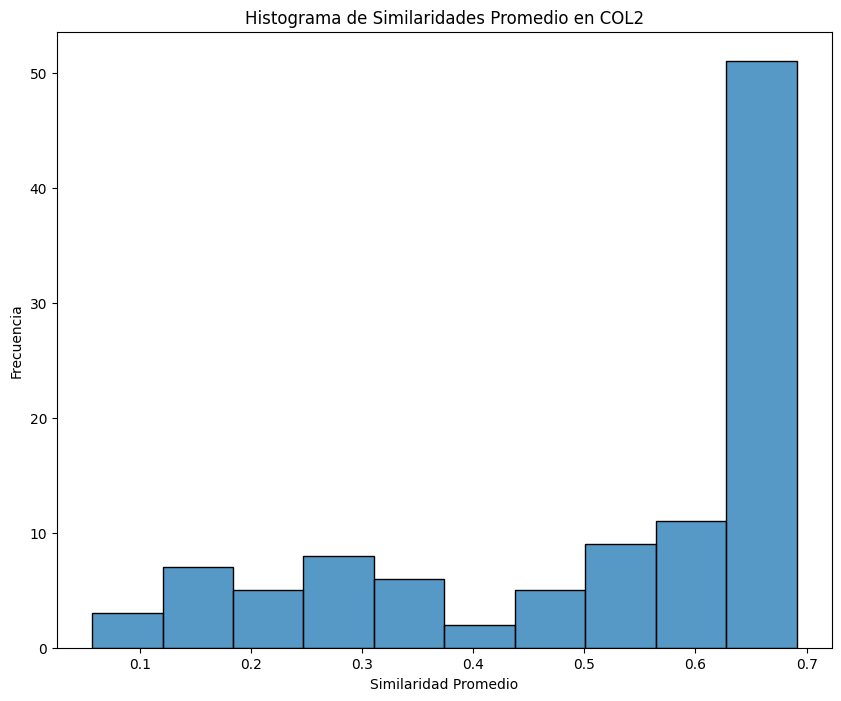

In [29]:
# Graficar un histograma de las similaridades promedio de los documentos en la COL2
plt.figure(figsize=(10, 8))
sns.histplot(similaridades_promedio_col2, bins=10, kde=False)
plt.title("Histograma de Similaridades Promedio en COL2")
plt.xlabel("Similaridad Promedio")
plt.ylabel("Frecuencia")
plt.show() 
